<a href="https://colab.research.google.com/github/MS-H2020/Open/blob/main/Determining_MR_Image_Planes_(_Brain_Tumor_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [RSNA-MICCAI Brain Tumor Radiogenomic Classification](https://www.kaggle.com/competitions/rsna-miccai-brain-tumor-radiogenomic-classification)

## Refference

[Determining MR Image Planes](https://www.kaggle.com/code/davidbroberts/determining-mr-image-planes)

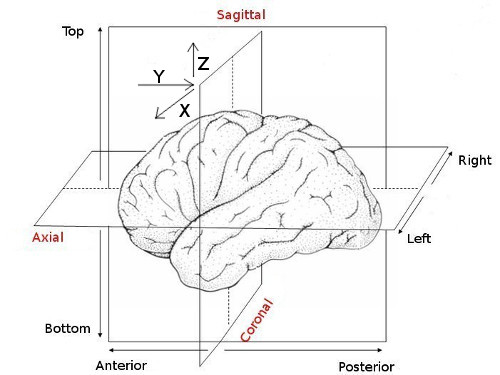

- Calculate the plane (Axial, Coronal, Sagittal) of an MR image relative to the patient's body using the DICOM Image Orientation Patient tag.¶
- It is important to compare co-planar images, i.e. Axial to Axial, Coronal to Coronal etc.

    - I noticed that the series aren't standard across studies with respect to the reconstruction planes.
    - That is, in some studies, the FLAIR sequence is in the Coronal plane and in the Sagittal plane in other studies etc.


## 1. Import stuff and define some functions

In [1]:
#!pip install pydicom

  Using cached pydicom-2.4.4-py3-none-any.whl.metadata (7.8 kB)
Using cached pydicom-2.4.4-py3-none-any.whl (1.8 MB)


In [1]:
import os
import numpy as np
import pandas as pd
import pydicom
import matplotlib.pyplot as plt

In [28]:
# specify the dataset and the series names
dataset = 'test'
series_names = ['FLAIR','T1w','T1wCE','T2w']
directory = '../01_input/rsna-miccai-brain-tumor-radiogenomic-classification'

In [29]:
#import shutil
#shutil.unpack_archive(directory+'.zip',directory)

In [3]:
def get_series_list(path):
    files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    return files

In [4]:
def get_series_list(path):
    files = [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    return files

In [5]:
# Find the image in the middle of each series stack, returns a list of four images
def get_middle_images(study_id):

    middle_images = []

    # Iterate through each of the four series directories and get the files
    for ser in series_names:
        series_files = get_series_list(f'{directory}/{dataset}/{study_id}/{ser}')
        series_df = pd.DataFrame(columns = ['image','instance_number'])

        # Get the DICOM InstanceNumber tag to order the images since we can't rely on the filenames to be in order
        for s in series_files:
            img = pydicom.dcmread(s)
            series_df.loc[len(series_df.index)] = [s, img[0x0020,0x0013].value]

        series_df['instance_number'] = pd.to_numeric(series_df['instance_number'])

        # Sort the image list by InstanceNumber
        series_df = series_df.sort_values(by=['instance_number'])

        # Find the image in the middle of the list
        middle_index = int(series_df.shape[0] / 2)
        middle_image = series_df.iloc[middle_index]['image']

        middle_images.append(middle_image)

    return middle_images

In [6]:
# Convert the Image Orientation Patient tag cosine values into a text string of the plane.
# This represents the plane the image is 'closest to' .. it does not explain any obliqueness
def get_image_plane(loc):

    row_x = round(loc[0])
    row_y = round(loc[1])
    row_z = round(loc[2])
    col_x = round(loc[3])
    col_y = round(loc[4])
    col_z = round(loc[5])

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 0:
        return "Coronal"

    if row_x == 0 and row_y == 1 and col_x == 0 and col_y == 0:
        return "Sagittal"

    if row_x == 1 and row_y == 0 and col_x == 0 and col_y == 1:
        return "Axial"

    return "Unknown"

In [7]:
# Display images and their plane
def plot_images(images):
    for img in images:
        fig = plt.figure(figsize=(5, 5))
        image = pydicom.dcmread(img)
        ser = img.split("/")
        image_orientation_patient = image[0x0020,0x0037]
        plane = get_image_plane(image_orientation_patient)
        plt.title(ser[-2] + " - " + plane)
        plt.imshow(image.pixel_array, cmap='gray')


## 2. Load four images from a study

- Grab the 'middle' image of each sequence
- Get the plane of each image/sequence

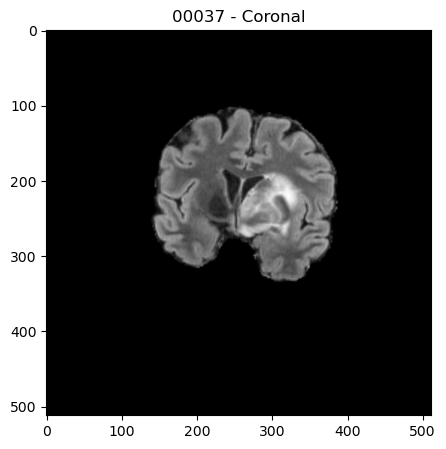

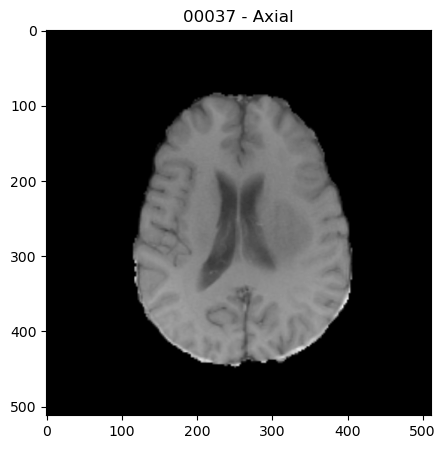

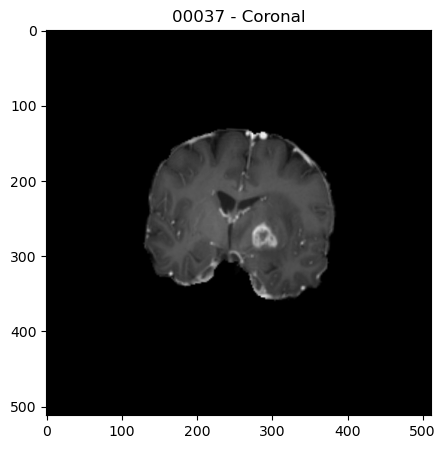

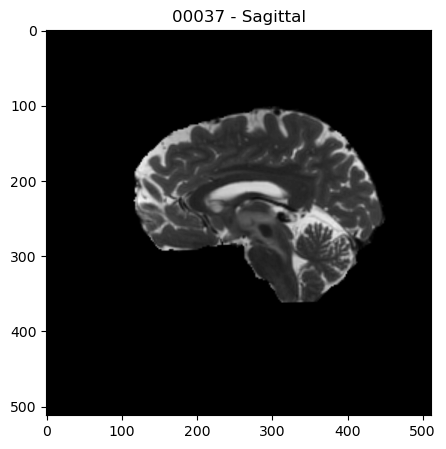

In [30]:
# ID / Directory name of the study we want to get
study_id = '00037'
plot_images(get_middle_images(study_id))

We can see this study has the following planes for each sequence:  

- FLAIR = Coronal
- T1w = Axial
- T1wCE = Coronal
- T2w = Sagittal

Let's get another study to compare

(256, 192, 3)


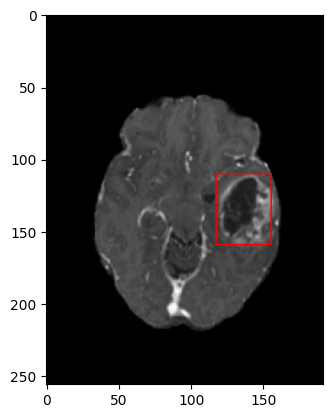

In [ ]:
study_id = '00079'
plot_images(get_middle_images(study_id))

Compare the planes between the two studies

Second Study:

- FLAIR = Sagittal
- T1w = Axial
- T1wCE = Sagittal
- T2w = Sagittal

First study:

- FLAIR = Coronal
- T1w = Axial
- T1wCE = Coronal
- T2w = Sagittal

As you can see, the planes are different, so they can't be directly compared to each other.